In [1]:

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import IPython
from glob import glob
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import tqdm
#import seaborn as sns
import albumentations as A
import torch
import torch.nn as nn
import timm
import torcheval 
import wandb
import torchvision
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import seaborn as sns
from albumentations.pytorch import ToTensorV2
plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})
import psutil
import imageio.v3 as imageio
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler , MinMaxScaler
import scipy as sp



def Show_Image(Image, Picture_Name):
    plt.imshow(Image)
    plt.title(Picture_Name)
    plt.show()


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [7]:
class Config():

    BASE_DIR = os.path.join(os.getcwd() , 'data')
    train_df = pd.read_csv(BASE_DIR  +  '/train.csv')
    TRAIN_VAL_SPLIT_SIZE = 0.14
    TRAIN_BATCH_SIZE = 24
    VAL_BATCH_SIZE =  2
    TEST_BATCH_SIZE = 2
    LR_MAX = 1e-4
    NUM_EPOCHS = 10
    TIM_NUM_CLASS =6 # 
    NORMALIZE_TARGET = "log_transform_mean_std"   #"log_transform" #
    RANDOM_NUMBER = 42
    NUM_FLODS  = 5
    NUM_CLASSES = 6
    TRAITS_NAME = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]
    FOLD = 0 # Which fold to set as validation data
    IMAGE_SIZE =128
    TARGET_IMAGE_SIZE =  256
    T_MAX =        9
    LR_MODE = "step" # LR scheduler mode from one of "cos", "step", "exp"
    torch.manual_seed(RANDOM_NUMBER)
    INCLUDE_EXTRA_FEATURES = True
    EXTRA_FEATURES_NORMALIZATION = "standard_scalar"  #"min_max_normalization"  #
    WEIGHT_DECAY = 0.01
    TABULAR_NN_OUTPUT  = 256
    TIM_MODEL_NAME = "swinV2" #"swin_large" #"efficientnet_v2" # 
    TIMM_FINED_TUNED_WEIGHT = f'{BASE_DIR}/model_08_ensemble.pth'
    Lower_Quantile = 0.005
    Upper_Quantile = 0.98 #0.985
    WANDB_INIT = True
    
    
CONFIG = Config()

In [8]:
train_transform =A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.GaussNoise(),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE,interpolation= cv2.INTER_LINEAR,p=0.5),
        A.ToFloat(),
        A.Normalize([0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225], max_pixel_value=1),
        ToTensorV2(),
    ])


In [11]:
BASE_DIR =CONFIG.BASE_DIR
Train_DF = pd.read_csv(BASE_DIR  +  '/train.csv')  #.iloc[:-10000]
Test_DF =  pd.read_csv(BASE_DIR  +  '/test.csv')
Test_DF[CONFIG.TRAITS_NAME] =1

train_df , val_df = train_test_split(Train_DF,test_size=CONFIG.TRAIN_VAL_SPLIT_SIZE,shuffle=True)
for column in CONFIG.TRAITS_NAME:
    lower_quantile = train_df[column].quantile(CONFIG.Lower_Quantile)
    upper_quantile = train_df[column].quantile(CONFIG.Upper_Quantile)
    train_df = train_df[(train_df[column] >= lower_quantile) & (train_df[column] <= upper_quantile)]



print('JPEG Files Processing:')
train_df['file_path'] = train_df['id'].apply(lambda s: f'{BASE_DIR}/train_images/{s}.jpeg')
train_df['jpeg_bytes'] = train_df['file_path'].apply(lambda fp: open(fp, 'rb').read())

val_df['file_path'] = val_df['id'].apply(lambda s: f'{BASE_DIR}/train_images/{s}.jpeg')
val_df['jpeg_bytes'] = val_df['file_path'].apply(lambda fp: open(fp, 'rb').read())

Test_DF['file_path'] = Test_DF['id'].apply(lambda s: f'{BASE_DIR}/test_images/{s}.jpeg')
Test_DF['jpeg_bytes'] = Test_DF['file_path'].apply(lambda fp: open(fp, 'rb').read())
print('JPEG Files Processing End')   

JPEG Files Processing:
JPEG Files Processing End


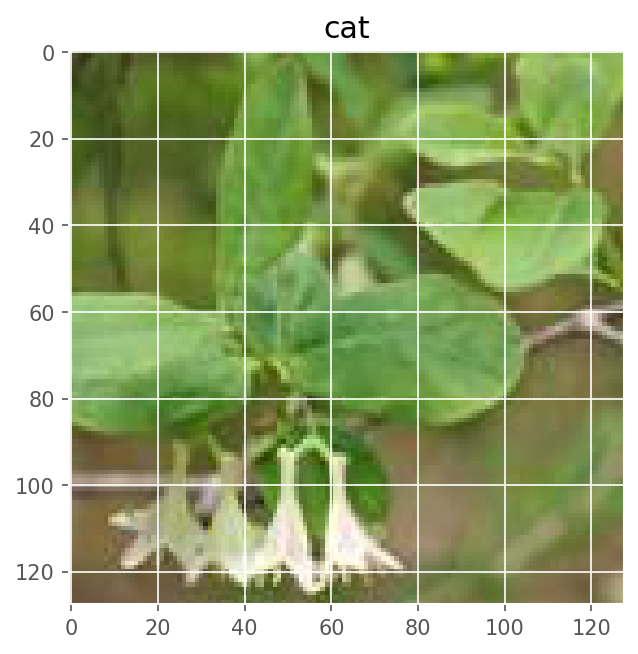

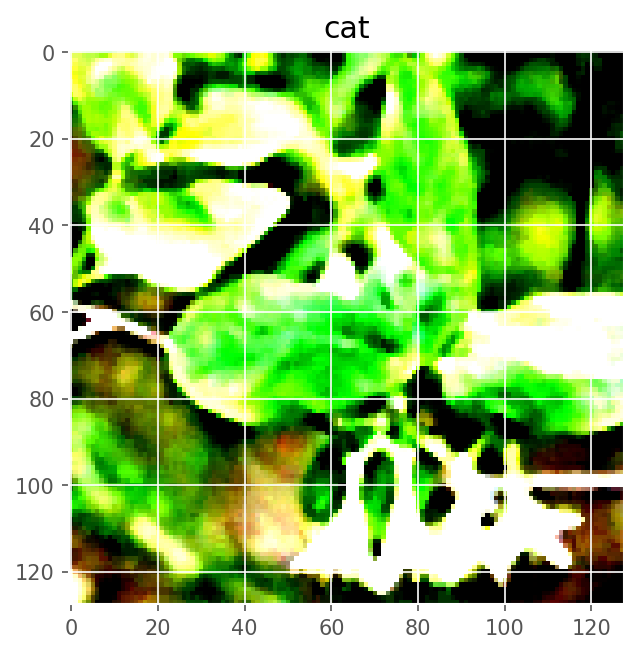

In [26]:
img = plt.imread(train_df.iloc[88]["file_path"])
img2 = train_transform(image = img)["image"]
Show_Image( img, 'cat')
Show_Image( img2.permute(1, 2, 0), 'cat')

In [28]:
EXTRA_COLOUMN = ['WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO12_annual_precipitation',
       'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
       'WORLDCLIM_BIO15_precipitation_seasonality',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'WORLDCLIM_BIO7_temperature_annual_range',
       'SOIL_bdod_0.5cm_mean_0.01_deg',
       'SOIL_bdod_100.200cm_mean_0.01_deg',
       'SOIL_bdod_15.30cm_mean_0.01_deg',
       'SOIL_bdod_30.60cm_mean_0.01_deg',
       'SOIL_bdod_5.15cm_mean_0.01_deg',
       'SOIL_bdod_60.100cm_mean_0.01_deg', 'SOIL_cec_0.5cm_mean_0.01_deg',
       'SOIL_cec_100.200cm_mean_0.01_deg',
       'SOIL_cec_15.30cm_mean_0.01_deg', 'SOIL_cec_30.60cm_mean_0.01_deg',
       'SOIL_cec_5.15cm_mean_0.01_deg', 'SOIL_cec_60.100cm_mean_0.01_deg',
       'SOIL_cfvo_0.5cm_mean_0.01_deg',
       'SOIL_cfvo_100.200cm_mean_0.01_deg',
       'SOIL_cfvo_15.30cm_mean_0.01_deg',
       'SOIL_cfvo_30.60cm_mean_0.01_deg',
       'SOIL_cfvo_5.15cm_mean_0.01_deg',
       'SOIL_cfvo_60.100cm_mean_0.01_deg',
       'SOIL_clay_0.5cm_mean_0.01_deg',
       'SOIL_clay_100.200cm_mean_0.01_deg',
       'SOIL_clay_15.30cm_mean_0.01_deg',
       'SOIL_clay_30.60cm_mean_0.01_deg',
       'SOIL_clay_5.15cm_mean_0.01_deg',
       'SOIL_clay_60.100cm_mean_0.01_deg',
       'SOIL_nitrogen_0.5cm_mean_0.01_deg',
       'SOIL_nitrogen_100.200cm_mean_0.01_deg',
       'SOIL_nitrogen_15.30cm_mean_0.01_deg',
       'SOIL_nitrogen_30.60cm_mean_0.01_deg',
       'SOIL_nitrogen_5.15cm_mean_0.01_deg',
       'SOIL_nitrogen_60.100cm_mean_0.01_deg',
       'SOIL_ocd_0.5cm_mean_0.01_deg', 'SOIL_ocd_100.200cm_mean_0.01_deg',
       'SOIL_ocd_15.30cm_mean_0.01_deg', 'SOIL_ocd_30.60cm_mean_0.01_deg',
       'SOIL_ocd_5.15cm_mean_0.01_deg', 'SOIL_ocd_60.100cm_mean_0.01_deg',
       'SOIL_ocs_0.30cm_mean_0.01_deg', 'SOIL_phh2o_0.5cm_mean_0.01_deg',
       'SOIL_phh2o_100.200cm_mean_0.01_deg',
       'SOIL_phh2o_15.30cm_mean_0.01_deg',
       'SOIL_phh2o_30.60cm_mean_0.01_deg',
       'SOIL_phh2o_5.15cm_mean_0.01_deg',
       'SOIL_phh2o_60.100cm_mean_0.01_deg',
       'SOIL_sand_0.5cm_mean_0.01_deg',
       'SOIL_sand_100.200cm_mean_0.01_deg',
       'SOIL_sand_15.30cm_mean_0.01_deg',
       'SOIL_sand_30.60cm_mean_0.01_deg',
       'SOIL_sand_5.15cm_mean_0.01_deg',
       'SOIL_sand_60.100cm_mean_0.01_deg',
       'SOIL_silt_0.5cm_mean_0.01_deg',
       'SOIL_silt_100.200cm_mean_0.01_deg',
       'SOIL_silt_15.30cm_mean_0.01_deg',
       'SOIL_silt_30.60cm_mean_0.01_deg',
       'SOIL_silt_5.15cm_mean_0.01_deg',
       'SOIL_silt_60.100cm_mean_0.01_deg', 'SOIL_soc_0.5cm_mean_0.01_deg',
       'SOIL_soc_100.200cm_mean_0.01_deg',
       'SOIL_soc_15.30cm_mean_0.01_deg', 'SOIL_soc_30.60cm_mean_0.01_deg',
       'SOIL_soc_5.15cm_mean_0.01_deg', 'SOIL_soc_60.100cm_mean_0.01_deg',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m9',
       'VOD_C_2002_2018_multiyear_mean_m01',
       'VOD_C_2002_2018_multiyear_mean_m02',
       'VOD_C_2002_2018_multiyear_mean_m03',
       'VOD_C_2002_2018_multiyear_mean_m04',
       'VOD_C_2002_2018_multiyear_mean_m05',
       'VOD_C_2002_2018_multiyear_mean_m06',
       'VOD_C_2002_2018_multiyear_mean_m07',
       'VOD_C_2002_2018_multiyear_mean_m08',
       'VOD_C_2002_2018_multiyear_mean_m09',
       'VOD_C_2002_2018_multiyear_mean_m10',
       'VOD_C_2002_2018_multiyear_mean_m11',
       'VOD_C_2002_2018_multiyear_mean_m12',
       'VOD_Ku_1987_2017_multiyear_mean_m01',
       'VOD_Ku_1987_2017_multiyear_mean_m02',
       'VOD_Ku_1987_2017_multiyear_mean_m03',
       'VOD_Ku_1987_2017_multiyear_mean_m04',
       'VOD_Ku_1987_2017_multiyear_mean_m05',
       'VOD_Ku_1987_2017_multiyear_mean_m06',
       'VOD_Ku_1987_2017_multiyear_mean_m07',
       'VOD_Ku_1987_2017_multiyear_mean_m08',
       'VOD_Ku_1987_2017_multiyear_mean_m09',
       'VOD_Ku_1987_2017_multiyear_mean_m10',
       'VOD_Ku_1987_2017_multiyear_mean_m11',
       'VOD_Ku_1987_2017_multiyear_mean_m12',
       'VOD_X_1997_2018_multiyear_mean_m01',
       'VOD_X_1997_2018_multiyear_mean_m02',
       'VOD_X_1997_2018_multiyear_mean_m03',
       'VOD_X_1997_2018_multiyear_mean_m04',
       'VOD_X_1997_2018_multiyear_mean_m05',
       'VOD_X_1997_2018_multiyear_mean_m06',
       'VOD_X_1997_2018_multiyear_mean_m07',
       'VOD_X_1997_2018_multiyear_mean_m08',
       'VOD_X_1997_2018_multiyear_mean_m09',
       'VOD_X_1997_2018_multiyear_mean_m10',
       'VOD_X_1997_2018_multiyear_mean_m11',
       'VOD_X_1997_2018_multiyear_mean_m12'
       ]
    N_TARGETS  =len(EXTRA_COLOUMN)  

In [30]:
    EXTRA_COLOUMN = ['WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO12_annual_precipitation',
       'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
       'WORLDCLIM_BIO15_precipitation_seasonality',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'WORLDCLIM_BIO7_temperature_annual_range',
       'SOIL_bdod_0.5cm_mean_0.01_deg',
       'SOIL_bdod_100.200cm_mean_0.01_deg',
       'SOIL_bdod_15.30cm_mean_0.01_deg',
       'SOIL_bdod_30.60cm_mean_0.01_deg',
       'SOIL_bdod_5.15cm_mean_0.01_deg',
       'SOIL_bdod_60.100cm_mean_0.01_deg', 'SOIL_cec_0.5cm_mean_0.01_deg',
       'SOIL_cec_100.200cm_mean_0.01_deg',
       'SOIL_cec_15.30cm_mean_0.01_deg', 'SOIL_cec_30.60cm_mean_0.01_deg',
       'SOIL_cec_5.15cm_mean_0.01_deg', 'SOIL_cec_60.100cm_mean_0.01_deg',
       'SOIL_cfvo_0.5cm_mean_0.01_deg',
       'SOIL_cfvo_100.200cm_mean_0.01_deg',
       'SOIL_cfvo_15.30cm_mean_0.01_deg',
       'SOIL_cfvo_30.60cm_mean_0.01_deg',
       'SOIL_cfvo_5.15cm_mean_0.01_deg',
       'SOIL_cfvo_60.100cm_mean_0.01_deg',
       'SOIL_clay_0.5cm_mean_0.01_deg',
       'SOIL_clay_100.200cm_mean_0.01_deg',
       'SOIL_clay_15.30cm_mean_0.01_deg',
       'SOIL_clay_30.60cm_mean_0.01_deg',
       'SOIL_clay_5.15cm_mean_0.01_deg',
       'SOIL_clay_60.100cm_mean_0.01_deg',
       'SOIL_nitrogen_0.5cm_mean_0.01_deg',
       'SOIL_nitrogen_100.200cm_mean_0.01_deg',
       'SOIL_nitrogen_15.30cm_mean_0.01_deg',
       'SOIL_nitrogen_30.60cm_mean_0.01_deg',
       'SOIL_nitrogen_5.15cm_mean_0.01_deg',
       'SOIL_nitrogen_60.100cm_mean_0.01_deg',
       'SOIL_ocd_0.5cm_mean_0.01_deg', 'SOIL_ocd_100.200cm_mean_0.01_deg',
       'SOIL_ocd_15.30cm_mean_0.01_deg', 'SOIL_ocd_30.60cm_mean_0.01_deg',
       'SOIL_ocd_5.15cm_mean_0.01_deg', 'SOIL_ocd_60.100cm_mean_0.01_deg',
       'SOIL_ocs_0.30cm_mean_0.01_deg', 'SOIL_phh2o_0.5cm_mean_0.01_deg',
       'SOIL_phh2o_100.200cm_mean_0.01_deg',
       'SOIL_phh2o_15.30cm_mean_0.01_deg',
       'SOIL_phh2o_30.60cm_mean_0.01_deg',
       'SOIL_phh2o_5.15cm_mean_0.01_deg',
       'SOIL_phh2o_60.100cm_mean_0.01_deg',
       'SOIL_sand_0.5cm_mean_0.01_deg',
       'SOIL_sand_100.200cm_mean_0.01_deg',
       'SOIL_sand_15.30cm_mean_0.01_deg',
       'SOIL_sand_30.60cm_mean_0.01_deg',
       'SOIL_sand_5.15cm_mean_0.01_deg',
       'SOIL_sand_60.100cm_mean_0.01_deg',
       'SOIL_silt_0.5cm_mean_0.01_deg',
       'SOIL_silt_100.200cm_mean_0.01_deg',
       'SOIL_silt_15.30cm_mean_0.01_deg',
       'SOIL_silt_30.60cm_mean_0.01_deg',
       'SOIL_silt_5.15cm_mean_0.01_deg',
       'SOIL_silt_60.100cm_mean_0.01_deg', 'SOIL_soc_0.5cm_mean_0.01_deg',
       'SOIL_soc_100.200cm_mean_0.01_deg',
       'SOIL_soc_15.30cm_mean_0.01_deg', 'SOIL_soc_30.60cm_mean_0.01_deg',
       'SOIL_soc_5.15cm_mean_0.01_deg', 'SOIL_soc_60.100cm_mean_0.01_deg',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m9',
       'VOD_C_2002_2018_multiyear_mean_m01',
       'VOD_C_2002_2018_multiyear_mean_m02',
       'VOD_C_2002_2018_multiyear_mean_m03',
       'VOD_C_2002_2018_multiyear_mean_m04',
       'VOD_C_2002_2018_multiyear_mean_m05',
       'VOD_C_2002_2018_multiyear_mean_m06',
       'VOD_C_2002_2018_multiyear_mean_m07',
       'VOD_C_2002_2018_multiyear_mean_m08',
       'VOD_C_2002_2018_multiyear_mean_m09',
       'VOD_C_2002_2018_multiyear_mean_m10',
       'VOD_C_2002_2018_multiyear_mean_m11',
       'VOD_C_2002_2018_multiyear_mean_m12',
       'VOD_Ku_1987_2017_multiyear_mean_m01',
       'VOD_Ku_1987_2017_multiyear_mean_m02',
       'VOD_Ku_1987_2017_multiyear_mean_m03',
       'VOD_Ku_1987_2017_multiyear_mean_m04',
       'VOD_Ku_1987_2017_multiyear_mean_m05',
       'VOD_Ku_1987_2017_multiyear_mean_m06',
       'VOD_Ku_1987_2017_multiyear_mean_m07',
       'VOD_Ku_1987_2017_multiyear_mean_m08',
       'VOD_Ku_1987_2017_multiyear_mean_m09',
       'VOD_Ku_1987_2017_multiyear_mean_m10',
       'VOD_Ku_1987_2017_multiyear_mean_m11',
       'VOD_Ku_1987_2017_multiyear_mean_m12',
       'VOD_X_1997_2018_multiyear_mean_m01',
       'VOD_X_1997_2018_multiyear_mean_m02',
       'VOD_X_1997_2018_multiyear_mean_m03',
       'VOD_X_1997_2018_multiyear_mean_m04',
       'VOD_X_1997_2018_multiyear_mean_m05',
       'VOD_X_1997_2018_multiyear_mean_m06',
       'VOD_X_1997_2018_multiyear_mean_m07',
       'VOD_X_1997_2018_multiyear_mean_m08',
       'VOD_X_1997_2018_multiyear_mean_m09',
       'VOD_X_1997_2018_multiyear_mean_m10',
       'VOD_X_1997_2018_multiyear_mean_m11',
       'VOD_X_1997_2018_multiyear_mean_m12'
       ]

In [31]:
len(EXTRA_COLOUMN)

163